# Solve the problem leveraging MobileNet architecture
In this notebook, we will use the MobileNet architecture for our classification problem.

First, we'll try a simple **feature extraction**. Since the architecture was trained on a different dataset, we do not expect very good performance, but we can use these results as a baseline for the next step: **fine-tuning**.

## Import Libraries
First of all, let's import all the libraries we will need later.

In [1]:
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

## Set Parameters

In [2]:
DATASET_PATH = "SplittedDataset"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

LOCAL_MODELS_FOLDER = "content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "content/drive/My Drive/Baldi_Cioffo/models/mobilenet"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

## Utility Functions

In [3]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the training set
  '''
  return image_dataset_from_directory(
    TRAINING_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the validation set
  '''
  return image_dataset_from_directory(
    VALIDATION_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  #metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  #Confusion Matrix
  cf_matrix = confusion_matrix(y_true, y_pred);
  sns.heatmap(cf_matrix, annot=True)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

## Load Dataset
The dataset, properly preprocessed, is now located in the local machine.

In [4]:
set_seed()

At this point we need to transform the images we have on disk into preprocessed tensors. 

We decided to use the size that ResNet-50 expects as input, which is 224x224, and to use batches of size 32.

In [5]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.


## Feature extraction

In [6]:
conv_base = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),alpha=1,include_top= False,weights="imagenet")

In [7]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [8]:
conv_base.trainable = False

### Experiment 1
In this first experiment we try a simple configuration with a single dense layer before the output layer, without regularization techniques.

In [9]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 62721     
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
______________________________________________

Epoch 1/30
200/200 [==============================] - 243s 1s/step - loss: 1.2426 - accuracy: 0.7169 - val_loss: 0.8981 - val_accuracy: 0.7022

Epoch 00001: val_loss improved from inf to 0.89807, saving model to content/models/experiment1_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 264s 1s/step - loss: 0.5928 - accuracy: 0.8124 - val_loss: 2.0036 - val_accuracy: 0.5718

Epoch 00002: val_loss did not improve from 0.89807
Epoch 3/30
200/200 [==============================] - 239s 1s/step - loss: 0.3735 - accuracy: 0.8707 - val_loss: 0.8031 - val_accuracy: 0.8189

Epoch 00003: val_loss improved from 0.89807 to 0.80311, saving model to content/models/experiment1_feature_extraction.h5
Epoch 4/30
200/200 [==============================] - 266s 1s/step - loss: 0.2330 - accuracy: 0.9090 - val_loss: 0.7200 - val_accuracy: 0.7913

Epoch 00004: val_loss improved from 0.80311 to 0.71997, saving model to content/models/experiment1_feature_extraction.h5
Epoch 5/30
200/200 [==============================] - 250s 1s/step - loss: 0.1269 - accuracy: 0.9487 - val_loss: 0.8250 - val_accuracy: 0.7617

Epoch 00005: val_loss did not improve from 0.71997
Epoch 6/30
200/200 [==============================] - 263s 1s/step - loss: 0.211

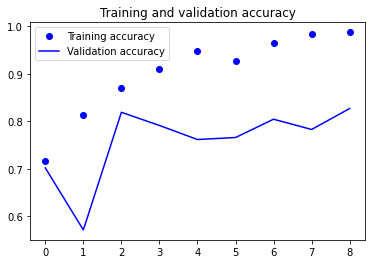

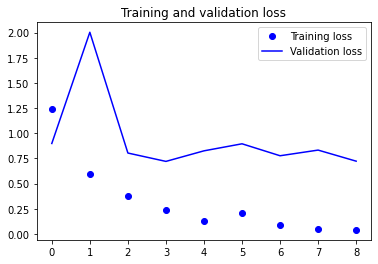

In [10]:
run_model(model1, 'experiment1_feature_extraction', epochs = 30, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.6971    0.7471    0.7212       696
           1     0.8730    0.8426    0.8575      1436

    accuracy                         0.8114      2132
   macro avg     0.7850    0.7949    0.7894      2132
weighted avg     0.8156    0.8114    0.8130      2132



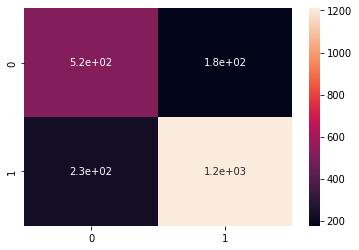

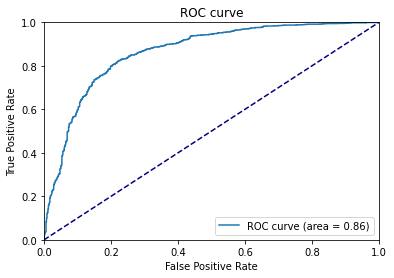

In [11]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5'))

### Experiment 2

In [12]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0   

Epoch 1/30
200/200 [==============================] - 278s 1s/step - loss: 0.7674 - accuracy: 0.7045 - val_loss: 0.4941 - val_accuracy: 0.7683

Epoch 00001: val_loss improved from inf to 0.49414, saving model to content/models/experiment2_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
200/200 [==============================] - 262s 1s/step - loss: 0.5233 - accuracy: 0.7589 - val_loss: 0.5075 - val_accuracy: 0.7598

Epoch 00002: val_loss did not improve from 0.49414
Epoch 3/30
200/200 [==============================] - 240s 1s/step - loss: 0.4968 - accuracy: 0.7683 - val_loss: 0.4527 - val_accuracy: 0.8021

Epoch 00003: val_loss improved from 0.49414 to 0.45265, saving model to content/models/experiment2_feature_extraction.h5
Epoch 4/30
200/200 [==============================] - 240s 1s/step - loss: 0.4685 - accuracy: 0.7846 - val_loss: 0.4710 - val_accuracy: 0.7852

Epoch 00004: val_loss did not improve from 0.45265
Epoch 5/30
200/200 [==============================] - 240s 1s/step - loss: 0.4532 - accuracy: 0.7853 - val_loss: 0.4845 - val_accuracy: 0.7725

Epoch 00005: val_loss did not improve from 0.45265
Epoch 6/30
200/200 [==============================] - 252s 1s/step - loss: 0.4417 - accuracy: 0.7944 - val_loss: 0.4363 - val_accuracy: 0.8096

Epoch 

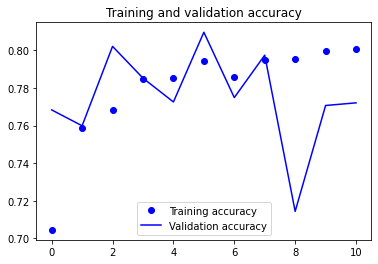

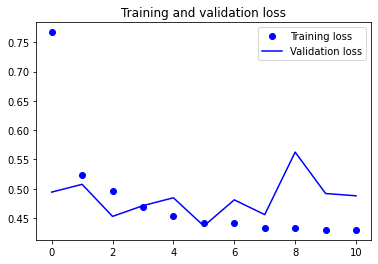

In [13]:
run_model(model2, 'experiment2_feature_extraction', epochs = 30, patience=5)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment2_feature_extraction.h5'))

### Experiment 3

In [15]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281

Epoch 1/50
200/200 [==============================] - 143s 689ms/step - loss: 0.6506 - accuracy: 0.6649 - val_loss: 0.5899 - val_accuracy: 0.6937

Epoch 00001: val_loss improved from inf to 0.58994, saving model to content/models/experiment3_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
200/200 [==============================] - 136s 682ms/step - loss: 0.5475 - accuracy: 0.7239 - val_loss: 0.5194 - val_accuracy: 0.7467

Epoch 00002: val_loss improved from 0.58994 to 0.51945, saving model to content/models/experiment3_feature_extraction.h5
Epoch 3/50
200/200 [==============================] - 136s 681ms/step - loss: 0.5252 - accuracy: 0.7417 - val_loss: 0.4964 - val_accuracy: 0.7598

Epoch 00003: val_loss improved from 0.51945 to 0.49644, saving model to content/models/experiment3_feature_extraction.h5
Epoch 4/50
200/200 [==============================] - 139s 694ms/step - loss: 0.5140 - accuracy: 0.7461 - val_loss: 0.5188 - val_accuracy: 0.7462

Epoch 00004: val_loss did not improve from 0.49644
Epoch 5/50
200/200 [==============================] - 139s 695ms/step - loss: 0.5111 - accuracy: 0.7503 - val_loss: 0.5170 - val_accuracy: 0.7444

Epoch 00005: val_loss did not improve from 0.49644
Epoch 6/50
200/200 [==============================] - 139s 694ms/ste

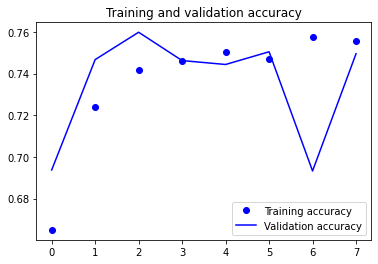

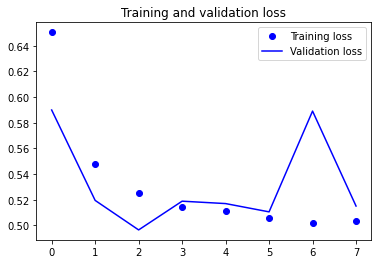

In [16]:
run_model(model3, 'experiment3_feature_extraction', epochs = 50, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.6127    0.7227    0.6632       696
           1     0.8528    0.7786    0.8140      1436

    accuracy                         0.7603      2132
   macro avg     0.7327    0.7506    0.7386      2132
weighted avg     0.7744    0.7603    0.7647      2132



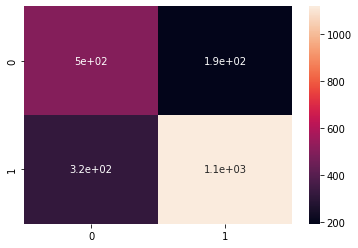

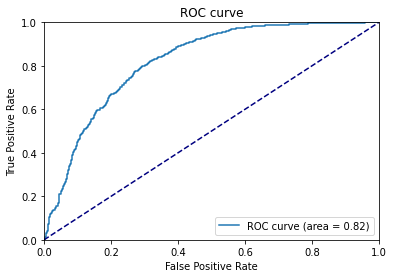

In [17]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment3_feature_extraction.h5'))

### Experiment 4

In [18]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model4, optimizer='rmsprop')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               2626

Epoch 1/50
200/200 [==============================] - 154s 744ms/step - loss: 0.6102 - accuracy: 0.7064 - val_loss: 0.4628 - val_accuracy: 0.7927

Epoch 00001: val_loss improved from inf to 0.46276, saving model to content/models/Experiment4_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
200/200 [==============================] - 141s 707ms/step - loss: 0.4984 - accuracy: 0.7620 - val_loss: 0.4470 - val_accuracy: 0.8091

Epoch 00002: val_loss improved from 0.46276 to 0.44695, saving model to content/models/Experiment4_feature_extraction.h5
Epoch 3/50
200/200 [==============================] - 139s 698ms/step - loss: 0.4670 - accuracy: 0.7781 - val_loss: 0.4708 - val_accuracy: 0.8035

Epoch 00003: val_loss did not improve from 0.44695
Epoch 4/50
200/200 [==============================] - 142s 710ms/step - loss: 0.4531 - accuracy: 0.7874 - val_loss: 0.4730 - val_accuracy: 0.7917

Epoch 00004: val_loss did not improve from 0.44695
Epoch 5/50
200/200 [==============================] - 146s 731ms/step - loss: 0.4331 - accuracy: 0.7939 - val_loss: 0.6076 - val_accuracy: 0.7866

Epoch 00005: val_loss did not improve from 0.44695
Epoch 6/50
200/200 [==============================] - 141s 703ms/step - loss: 0.4200 - accuracy: 0.8052 - val_loss: 0.4540 - val_accuracy:

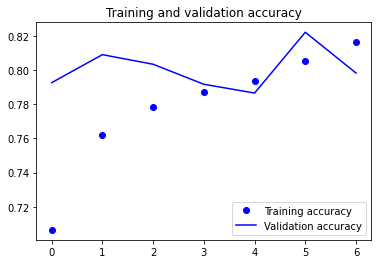

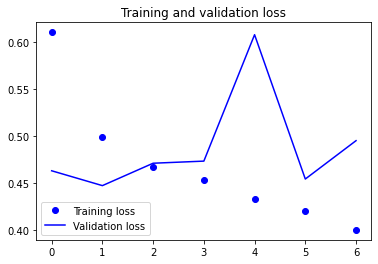

In [19]:
run_model(model4, "Experiment4_feature_extraction", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.7550    0.6552    0.7015       696
           1     0.8429    0.8969    0.8691      1436

    accuracy                         0.8180      2132
   macro avg     0.7989    0.7761    0.7853      2132
weighted avg     0.8142    0.8180    0.8144      2132



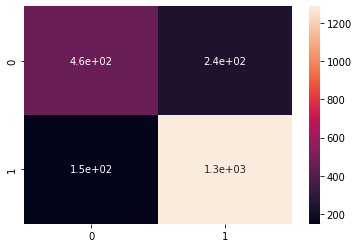

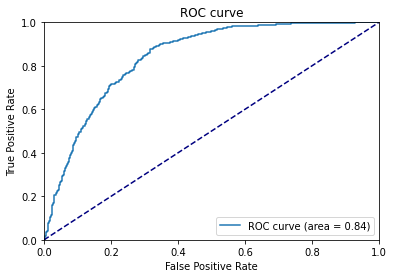

In [20]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_feature_extraction.h5'))

## Fine tuning

### Experiment 5

In [21]:
fine_tuning = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment3_feature_extraction.h5'))

setTrainable = False
for layer in fine_tuning.get_layer('mobilenetv2_1.00_224').layers:
    if layer.name in ('block_16_expand'):
        setTrainable = True
    if setTrainable == True:
        layer.trainable = True
    else:
      layer.trainable = False

compile_model(fine_tuning, learning_rate=1e-5)

for i, layer in enumerate(fine_tuning.get_layer('mobilenetv2_1.00_224').layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281

Epoch 1/100
200/200 [==============================] - 163s 788ms/step - loss: 0.5683 - accuracy: 0.7145 - val_loss: 0.5962 - val_accuracy: 0.6998

Epoch 00001: val_loss improved from inf to 0.59622, saving model to content/models/experiment5_finetuning.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
200/200 [==============================] - 155s 777ms/step - loss: 0.5142 - accuracy: 0.7481 - val_loss: 0.5922 - val_accuracy: 0.7026

Epoch 00002: val_loss improved from 0.59622 to 0.59220, saving model to content/models/experiment5_finetuning.h5
Epoch 3/100
200/200 [==============================] - 154s 769ms/step - loss: 0.5009 - accuracy: 0.7525 - val_loss: 0.6122 - val_accuracy: 0.6895

Epoch 00003: val_loss did not improve from 0.59220
Epoch 4/100
200/200 [==============================] - 154s 770ms/step - loss: 0.4755 - accuracy: 0.7636 - val_loss: 0.5980 - val_accuracy: 0.7012

Epoch 00004: val_loss did not improve from 0.59220
Epoch 5/100
200/200 [==============================] - 153s 766ms/step - loss: 0.4570 - accuracy: 0.7856 - val_loss: 0.6212 - val_accuracy: 0.6843

Epoch 00005: val_loss did not improve from 0.59220
Epoch 6/100
200/200 [==============================] - 160s 799ms/step - loss: 0.4497 - accuracy: 0.7846 - val_loss: 0.6407 - val_accuracy: 0.

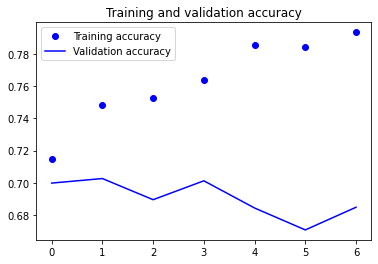

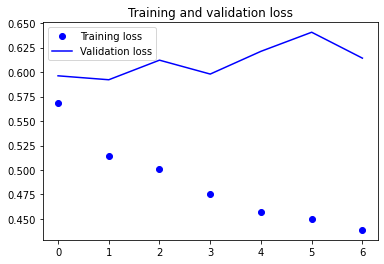

In [22]:
run_model(fine_tuning, 'experiment5_finetuning', epochs = 100, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.5380    0.8132    0.6476       696
           1     0.8796    0.6616    0.7552      1436

    accuracy                         0.7111      2132
   macro avg     0.7088    0.7374    0.7014      2132
weighted avg     0.7681    0.7111    0.7201      2132



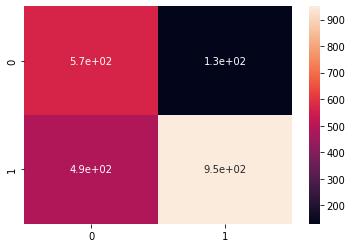

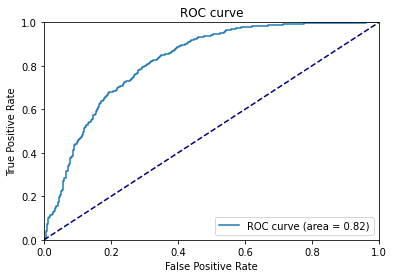

In [23]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment5_finetuning.h5'))

### Experiment 6

In [24]:
fine_tuning = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment2_feature_extraction.h5'))

setTrainable = False
for layer in fine_tuning.get_layer('mobilenetv2_1.00_224').layers:
    if layer.name in ('block_10_expand'):
        setTrainable = True
    if setTrainable == True:
        layer.trainable = True
    else:
      layer.trainable = False

compile_model(fine_tuning, learning_rate=1e-5)

for i, layer in enumerate(fine_tuning.get_layer('mobilenetv2_1.00_224').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0   

Epoch 1/100
200/200 [==============================] - 327s 2s/step - loss: 0.0082 - accuracy: 0.9980 - val_loss: 0.5643 - val_accuracy: 0.8466

Epoch 00001: val_loss improved from inf to 0.56429, saving model to content/models/experiment6_finetuning.h5
Epoch 2/100
200/200 [==============================] - 326s 2s/step - loss: 0.0082 - accuracy: 0.9983 - val_loss: 0.5368 - val_accuracy: 0.8565

Epoch 00002: val_loss improved from 0.56429 to 0.53678, saving model to content/models/experiment6_finetuning.h5
Epoch 3/100
200/200 [==============================] - 329s 2s/step - loss: 0.0054 - accuracy: 0.9998 - val_loss: 0.5237 - val_accuracy: 0.8677

Epoch 00003: val_loss improved from 0.53678 to 0.52365, saving model to content/models/experiment6_finetuning.h5
Epoch 4/100
200/200 [==============================] - 329s 2s/step - loss: 0.0065 - accuracy: 0.9989 - val_loss: 0.5401 - val_accuracy: 0.8616

Epoch 00004: val_loss did not improve from 0.52365
Epoch 5/100
200/200 [=============

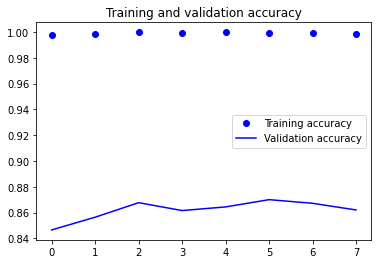

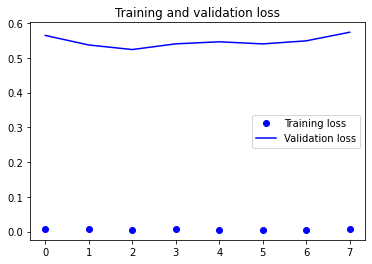

In [26]:
run_model(fine_tuning, 'experiment6_finetuning', epochs = 100, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.7901    0.8060    0.7980       696
           1     0.9051    0.8962    0.9006      1436

    accuracy                         0.8668      2132
   macro avg     0.8476    0.8511    0.8493      2132
weighted avg     0.8675    0.8668    0.8671      2132



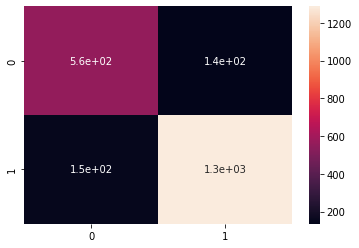

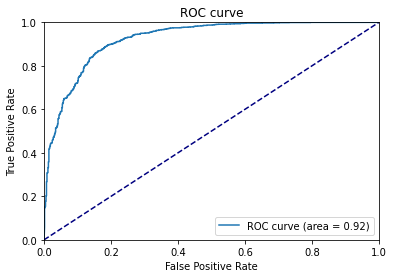

In [27]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment6_finetuning.h5'))

### Experiment 7

In [28]:
fine_tuning = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment3_feature_extraction.h5'))

setTrainable = False
for layer in fine_tuning.get_layer('mobilenetv2_1.00_224').layers:
    if layer.name in ('block_10_expand'):
        setTrainable = True
    if setTrainable == True:
        layer.trainable = True
    else:
      layer.trainable = False

compile_model(fine_tuning, learning_rate=1e-5)

for i, layer in enumerate(fine_tuning.get_layer('mobilenetv2_1.00_224').layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281

Epoch 1/100
200/200 [==============================] - 296s 1s/step - loss: 0.0207 - accuracy: 0.9962 - val_loss: 0.3753 - val_accuracy: 0.8780

Epoch 00001: val_loss improved from inf to 0.37534, saving model to content/models/experiment7_finetuning.h5
Epoch 2/100
200/200 [==============================] - 299s 1s/step - loss: 0.0193 - accuracy: 0.9958 - val_loss: 0.3797 - val_accuracy: 0.8832

Epoch 00002: val_loss did not improve from 0.37534
Epoch 3/100
200/200 [==============================] - 330s 2s/step - loss: 0.0140 - accuracy: 0.9975 - val_loss: 0.3899 - val_accuracy: 0.8841

Epoch 00003: val_loss did not improve from 0.37534
Epoch 4/100
200/200 [==============================] - 297s 1s/step - loss: 0.0127 - accuracy: 0.9984 - val_loss: 0.3953 - val_accuracy: 0.8841

Epoch 00004: val_loss did not improve from 0.37534
Epoch 5/100
200/200 [==============================] - 290s 1s/step - loss: 0.0135 - accuracy: 0.9978 - val_loss: 0.4144 - val_accuracy: 0.8827

Epoch 00005: 

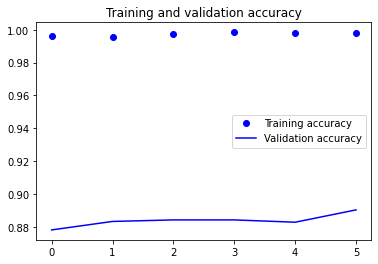

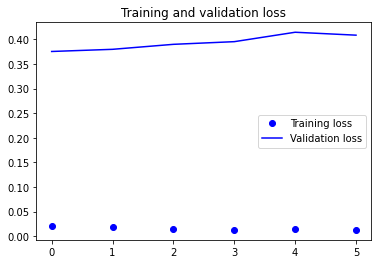

In [30]:
run_model(fine_tuning, 'experiment7_finetuning', epochs = 100, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.7848    0.8434    0.8130       696
           1     0.9212    0.8879    0.9043      1436

    accuracy                         0.8734      2132
   macro avg     0.8530    0.8656    0.8586      2132
weighted avg     0.8767    0.8734    0.8745      2132



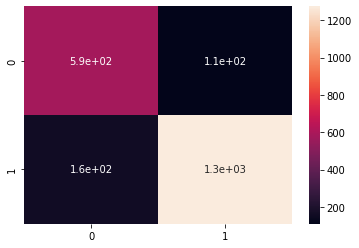

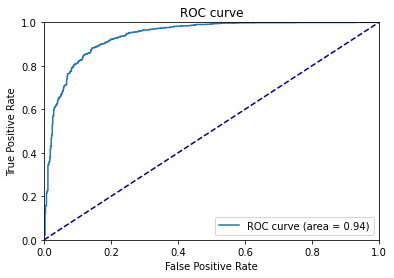

In [31]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment7_finetuning.h5'))

## Remove last block

In [32]:
def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index

In [33]:
conv_base = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),
    alpha=1,
    include_top= False,
    weights="imagenet",
)

In [34]:
base = Model(conv_base.input, conv_base.layers[get_index_by_layer_name(conv_base, 'block_15_add')].output, name='base')
base.trainable = False
base.summary()

Model: "base"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________________________

### Feature Extraction

#### Experiment 8

In [35]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 7, 7, 160)         1364864   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 160)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0   

Epoch 1/50
200/200 [==============================] - 191s 924ms/step - loss: 0.6633 - accuracy: 0.6967 - val_loss: 0.4776 - val_accuracy: 0.7711

Epoch 00001: val_loss improved from inf to 0.47758, saving model to content/models/experiment8_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
200/200 [==============================] - 185s 922ms/step - loss: 0.5443 - accuracy: 0.7395 - val_loss: 0.4444 - val_accuracy: 0.8091

Epoch 00002: val_loss improved from 0.47758 to 0.44436, saving model to content/models/experiment8_feature_extraction.h5
Epoch 3/50
200/200 [==============================] - 169s 844ms/step - loss: 0.5178 - accuracy: 0.7483 - val_loss: 0.5558 - val_accuracy: 0.7200

Epoch 00003: val_loss did not improve from 0.44436
Epoch 4/50
200/200 [==============================] - 185s 926ms/step - loss: 0.5043 - accuracy: 0.7594 - val_loss: 0.4458 - val_accuracy: 0.7946

Epoch 00004: val_loss did not improve from 0.44436
Epoch 5/50
200/200 [==============================] - 188s 942ms/step - loss: 0.4988 - accuracy: 0.7584 - val_loss: 0.4614 - val_accuracy: 0.7772

Epoch 00005: val_loss did not improve from 0.44436
Epoch 6/50
200/200 [==============================] - 182s 910ms/step - loss: 0.4932 - accuracy: 0.7602 - val_loss: 0.5892 - val_accuracy:

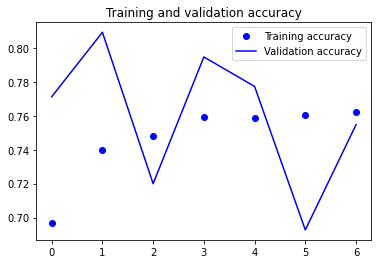

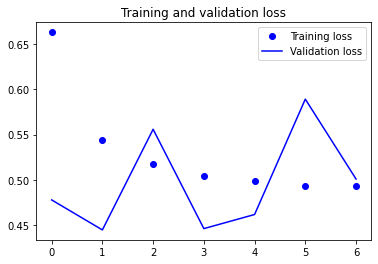

In [36]:
run_model(model2, 'experiment8_feature_extraction', epochs = 50, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.7623    0.5991    0.6710       696
           1     0.8240    0.9095    0.8646      1436

    accuracy                         0.8082      2132
   macro avg     0.7932    0.7543    0.7678      2132
weighted avg     0.8039    0.8082    0.8014      2132



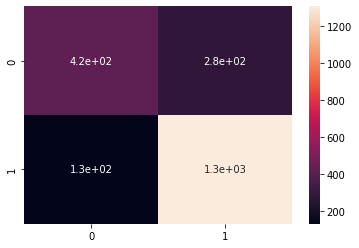

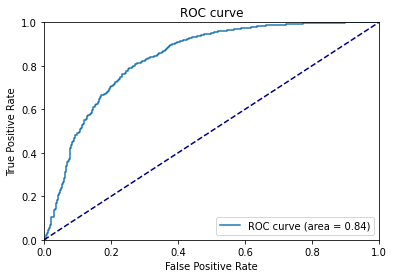

In [37]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment8_feature_extraction.h5'))

#### Experiment 9

In [38]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 7, 7, 160)         1364864   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 160)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 161 

Epoch 1/50
200/200 [==============================] - 190s 922ms/step - loss: 0.8138 - accuracy: 0.6127 - val_loss: 0.5431 - val_accuracy: 0.7355

Epoch 00001: val_loss improved from inf to 0.54313, saving model to content/models/experiment9_feature_extraction.h5


/home/cseb21/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
200/200 [==============================] - 186s 928ms/step - loss: 0.6616 - accuracy: 0.6673 - val_loss: 0.5198 - val_accuracy: 0.7566

Epoch 00002: val_loss improved from 0.54313 to 0.51978, saving model to content/models/experiment9_feature_extraction.h5
Epoch 3/50
200/200 [==============================] - 185s 927ms/step - loss: 0.5898 - accuracy: 0.6981 - val_loss: 0.5441 - val_accuracy: 0.7223

Epoch 00003: val_loss did not improve from 0.51978
Epoch 4/50
200/200 [==============================] - 180s 900ms/step - loss: 0.5708 - accuracy: 0.7067 - val_loss: 0.5146 - val_accuracy: 0.7542

Epoch 00004: val_loss improved from 0.51978 to 0.51460, saving model to content/models/experiment9_feature_extraction.h5
Epoch 5/50
200/200 [==============================] - 219s 1s/step - loss: 0.5603 - accuracy: 0.7164 - val_loss: 0.5404 - val_accuracy: 0.7280

Epoch 00005: val_loss did not improve from 0.51460
Epoch 6/50
200/200 [==============================] - 181s 903ms/step -

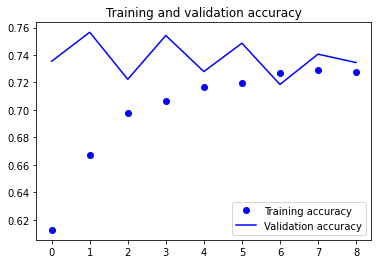

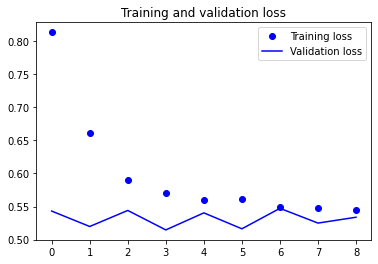

In [39]:
run_model(model3, 'experiment9_feature_extraction', epochs = 50, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.5961    0.7083    0.6474       696
           1     0.8444    0.7674    0.8041      1436

    accuracy                         0.7481      2132
   macro avg     0.7203    0.7379    0.7257      2132
weighted avg     0.7634    0.7481    0.7529      2132



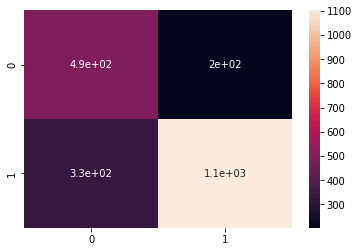

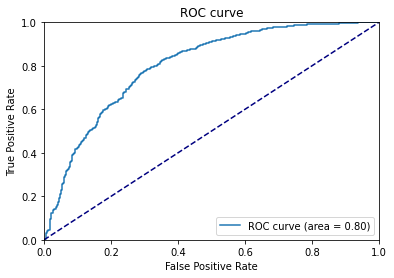

In [40]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment9_feature_extraction.h5'))

#### Experiment 10

In [53]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_7 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_7 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 7, 7, 160)         1364864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 7840)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2007296   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0   

Epoch 1/50
200/200 [==============================] - 73s 352ms/step - loss: 13.9437 - accuracy: 0.6750 - val_loss: 6.5741 - val_accuracy: 0.5849

Epoch 00001: val_loss improved from inf to 6.57410, saving model to content/models/experiment10_feature_extraction.h5
Epoch 2/50
200/200 [==============================] - 68s 342ms/step - loss: 3.4422 - accuracy: 0.7436 - val_loss: 1.4245 - val_accuracy: 0.7992

Epoch 00002: val_loss improved from 6.57410 to 1.42454, saving model to content/models/experiment10_feature_extraction.h5
Epoch 3/50
200/200 [==============================] - 71s 355ms/step - loss: 1.9908 - accuracy: 0.7561 - val_loss: 0.8754 - val_accuracy: 0.7528

Epoch 00003: val_loss improved from 1.42454 to 0.87540, saving model to content/models/experiment10_feature_extraction.h5
Epoch 4/50
200/200 [==============================] - 74s 368ms/step - loss: 0.5958 - accuracy: 0.7992 - val_loss: 0.7884 - val_accuracy: 0.6909

Epoch 00004: val_loss improved from 0.87540 to 0.7884

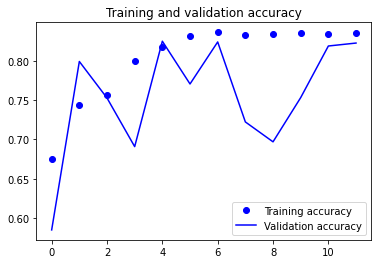

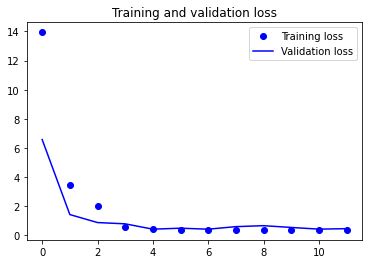

In [54]:
run_model(model2, 'experiment10_feature_extraction', epochs = 50, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.7569    0.6710    0.7113       696
           1     0.8488    0.8955    0.8716      1436

    accuracy                         0.8222      2132
   macro avg     0.8029    0.7833    0.7915      2132
weighted avg     0.8188    0.8222    0.8193      2132



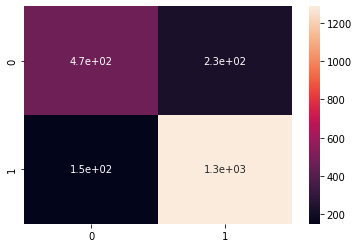

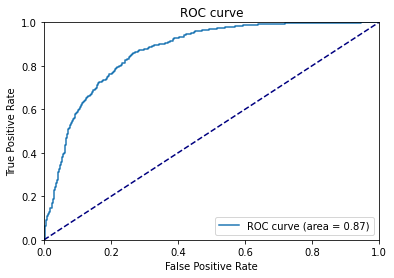

In [55]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment10_feature_extraction.h5'))

### Fine tuning

#### Experiment 11

In [74]:
fine_tuning = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER,'experiment8_feature_extraction.h5'))
setTrainable = False
for layer in fine_tuning.get_layer('base').layers:
    if layer.name in ('block_15_depthwise_BN'):
        setTrainable = True
    if setTrainable == True:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(fine_tuning, learning_rate=1e-5)

for i, layer in enumerate(fine_tuning.get_layer('base').layers):
    print(i, layer.name, layer.trainable)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
base (Functional)            (None, 7, 7, 160)         1364864   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 160)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0   

In [ ]:
run_model(fine_tuning, 'experiment11_fine_tuning_cut', epochs = 100, patience=5)

Epoch 1/100
200/200 [==============================] - 68s 340ms/step - loss: 0.3907 - accuracy: 0.8166 - val_loss: 0.4105 - val_accuracy: 0.8175

Epoch 00001: val_loss improved from inf to 0.41046, saving model to content/models/experiment11_fine_tuning_cut.h5
Epoch 2/100
200/200 [==============================] - 68s 340ms/step - loss: 0.3951 - accuracy: 0.8218 - val_loss: 0.4202 - val_accuracy: 0.8049

Epoch 00002: val_loss did not improve from 0.41046
Epoch 3/100
200/200 [==============================] - 69s 344ms/step - loss: 0.3929 - accuracy: 0.8169 - val_loss: 0.4124 - val_accuracy: 0.8143

Epoch 00003: val_loss did not improve from 0.41046
Epoch 4/100
200/200 [==============================] - 68s 341ms/step - loss: 0.3886 - accuracy: 0.8205 - val_loss: 0.4145 - val_accuracy: 0.8100

Epoch 00004: val_loss did not improve from 0.41046
Epoch 5/100
200/200 [==============================] - 69s 343ms/step - loss: 0.3904 - accuracy: 0.8235 - val_loss: 0.4306 - val_accuracy: 0.802

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment11_fine_tuning_cut.h5'))

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np


# Load the trained model
model_path = "content/drive/My Drive/Baldi_Cioffo/models/mobilenet/experiment7_finetuning.h5"
model = tf.keras.models.load_model(model_path)

# Function to preprocess the image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Provide the path of the image you want to predict
image_path = "Test2.bmp"

# Preprocess the image
target_size = (224,224)  # Use the same target size used during training
image_array = preprocess_image(image_path, target_size)

# Make the prediction
prediction = model.predict(image_array)
class_labels = ['hem','all']  # The class labels in the order used during training
predicted_class_index = np.argmax(prediction)
predicted_class = class_labels[predicted_class_index]

print("Predicted class:", predicted_class)


Predicted class: hem
